In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.linalg import sqrtm

In [21]:
# MSE error
def calc_error(r, target):
    return r - target

def calc_loss(r, target):
    return 0.5 * ((r - target)**2).mean()

def calc_accuracy_onehot(r, target):
    # one hot encoding of output
    b = np.zeros_like(r)
    b[np.where(r == np.amax(r))] = 1
    return np.linalg.norm(b * target)

def calc_accuracy_single(r, target, eps = 0.25):
    if np.abs(target - r) < eps:
        return 1.0
    else:
        return 0.0

def linear(x):
    return x

def d_linear(x):
    return np.ones_like(x)

def relu(x):
    return np.maximum(x, 0, x)

def d_relu(x):
    return np.heaviside(x, 0)

def logistic(x):
    return 1/(1 + np.exp(-x))

def d_logistic(x):
    y = logistic(x)
    return y * (1.0 - y)

def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    y = tanh(x)
    return 1 - y**2

def ds_pinv(r_array, w_matrix):

    covariance = np.cov(r_array.T)
    mean = np.mean(r_array, axis=0)
    gammasquared = covariance + np.outer(mean,mean)
    
    u_matrix, s_matrix, vh_matrix = np.linalg.svd(gammasquared)
    gamma = np.dot(np.dot(u_matrix, np.diag(np.sqrt(s_matrix))), vh_matrix)
    
    # gamma = sqrtm(gammasquared)
    #print(gamma.shape[0])
    
    # gamma = np.eye(gamma.shape[0])
    # print(gamma)

    gen_pseudo = np.dot(gamma, np.linalg.pinv(np.dot(w_matrix, gamma)))
    if not np.all(np.isreal(gen_pseudo) == True):
        print(gen_pseudo)
        raise ValueError('ds-pinv has not converged to real matrix')

    return gen_pseudo

def cos_sim(A, B):
    return np.trace(A.T @ B) / np.linalg.norm(A) / np.linalg.norm(B)

def sem(A):
    return np.std(A) / np.sqrt(len(A))

In [131]:
def calc_net(lr, layers, activation, d_activation, W_init, inputs, steps, algo, learn_W, bias, learn_bias, acc_measure, bw_lr = None, alpha = None, pinv_recalc = 4, print_steps = 10):

    number_layers = len(layers)
    e = [[] for layer in range(number_layers)]
    e_array = []
    loss_array = []
    acc_array = []
    r = [[] for layer in range(number_layers)]
    W_array = []
    B_array = []
    bias_array = []
    r_array = []
    bias_array.append(copy.deepcopy(bias))

    W = copy.deepcopy(W_init)
    
    W_array.append(copy.deepcopy(W_init))
    
    if algo in ['fa', 'dyn-pbp', 'gen-pbp']:
        pinv_counter = 0
        B = []
        for mat in W_init:
            # use uniform [0,1] init for FA backwards matrix
            B.append(np.random.uniform(0, 1, size=(mat.shape)).T)
    
    elif algo in ['pbp']:
        pinv_counter = 0
        B = []
        for mat in W_init:
            B.append(np.linalg.pinv(mat))

    for i in range(steps):
        if print_steps > 0:
            if i % (steps / print_steps) == 0:
                print("Working on step " , i)
        dW = [np.zeros_like(W) for W in W_init]
        dB = [np.zeros_like(W.T) for W in W_init]
        dbias = [np.zeros_like(bias) for bias in bias]
        
        # batch learn over all samples
        for j in range(len(inputs)):
            r[0] = inputs[j]
            target = targets[j]

            # fw pass
            for l in range(len(layers)-2):
                r[l+1] = activation(W[l] @ r[l] + bias[l])
            r[-1] = W[-1] @ r[-2] + bias[-1]

            # bw pass
            e[-1] = calc_error(r[-1], target)

            for k in range(len(layers)-2, -1, -1):
                if algo == 'bp':
                    e[k] = np.diag(d_activation(r[k])) @ W[k].T @ e[k+1]
                elif algo == 'fa':
                    e[k] = np.diag(d_activation(r[k])) @ B[k] @ e[k+1]
                elif algo in ['pbp', 'gen-pbp', 'dyn-pbp']:
                    e[k] = np.diag(d_activation(r[k])) @ B[k] @ e[k+1]

            # calculate weight update
            for l in range(len(layers)-1):
                if learn_W[l]:
                    dW[l] += np.outer(e[l+1], r[l])
                if learn_bias[l]:
                    dbias[l] += e[l+1]
                if algo == 'dyn-pbp':
                    dB[l] += np.outer(B[l] @ W[l] @ r[l] - r[l], W[l] @ r[l])
                    
            r_array.append(copy.deepcopy(r))     
            e_array.append(copy.deepcopy(e))
            W_array.append(copy.deepcopy(W))
            if algo in ['fa', 'pbp', 'gen-pbp', 'dyn-pbp']:
                B_array.append(copy.deepcopy(B))
            bias_array.append(copy.deepcopy(bias))
            loss_array.append(calc_loss(r[-1], target))
            
            if acc_measure == "onehot":
                acc_array.append(calc_accuracy_onehot(r[-1], target))
            elif acc_measure == "single":
                acc_array.append(calc_accuracy_single(r[-1][0], target))
                    
        # update weights
        for l in range(len(layers)-1):
            if learn_W[l]:
                W[l] -= lr * dW[l]
            if learn_bias[l]:
                bias[l] -= lr * dbias[l]
            if algo == 'dyn-pbp':
                B[l] -= bw_lr * (dB[l] - alpha * B[l])
        
        if algo in ['pbp', 'gen-pbp']:
            pinv_counter += 1
            if pinv_counter == pinv_recalc:
                for k in range(len(layers)-2, -1, -1):
                    if algo == 'pbp':
                        B[k] = np.linalg.pinv(W[k])
                    elif algo == 'gen-pbp':
                        # create a batch of r's since last recalc of backwards weights
                        r_batch = [r_array[-pinv_recalc:][i][k] for i in range(pinv_recalc)]
                        # catch an exeption where ds-pinv does not converge to a real matrix
                        try:
                            B[k] = ds_pinv(np.array(r_batch), W[k])
                        except ValueError:
                            print('ds-pinv has not converged to real matrix')
                            return _, _, _, _, _, _
                    pinv_counter = 0
    if algo in ['fa', 'pbp', 'gen-pbp', 'dyn-pbp']:
        return r_array, e_array, W_array, B_array, loss_array, acc_array
    else:
        return r_array, e_array, W_array, _, loss_array, acc_array

In [5]:
# plot options
labels = ['bp', 'fa', 'pbp', 'gen-pbp', 'dyn-pbp']
styles = ['g', 'b', 'r', 'y', 'black']

# The setup

 In order to limit the network to the smallest size, we use single-target encoding, i.e. the targets are encoded as -1 (for xor = zero) and +1 (for one).
 
 In combination with the input in the form [-1, -1] for [zero, zero] etc., this symmetrises the problem around positive and negative error propagation. Therefore, we should see that FA fails in ~50% of cases.
 
 Also, bias is deactivated because we want to stress how FA is not able to produce sign changes in the error signal.
 
 Therefore, we need a net of hidden layer size 3, i.e. 2-3-1. (?)
 
 A note on pinv_recalc:
 Here, we sample over all 4 examples given by xor. Therefore, pinv-recalc should be set to 4 or multiples of 4.

# Comparison of activation functions

Let's start by comparing the effect of different activation functions with backprop.

In [144]:
# define parameters of model
lr = 0.1
layers = [2, 3, 1]

inputs = np.array([[1, 0], [0, 1], [1, 1], [0, 0]])
targets = np.array([1, 1, 0, 0])

steps = 4000
seeds = 5

In [145]:
for activation in [[relu, d_relu], [logistic, d_logistic], [tanh, d_tanh]]:
    acc = []
    for seed in range(seeds):

        np.random.seed(seed)
        init_val = 1
        W1_init = np.random.uniform(-init_val, init_val, size=(layers[1], layers[0]))
        W2_init = np.random.uniform(-init_val, init_val, size=(layers[2], layers[1]))
        # W1_init = np.random.normal(0, 1, size=(layers[1], layers[0]))
        # W2_init = np.random.normal(0, 1, size=(layers[2], layers[1]))
        bias_init = [np.zeros(layers[1]), np.zeros(layers[2])]
        W_init = [W1_init, W2_init]

        _, _, _, _, _, acc_array_bp = calc_net(lr, layers, activation[0], activation[1], W_init, inputs, steps, 'bp', learn_W = [True]*(len(layers)-1), bias = bias_init, learn_bias = [False]*(len(layers)-1), acc_measure = 'single', print_steps=0)

        acc.append(np.mean(acc_array_bp[-100:]))
        print('accuracy over last 100 samples: ', acc[-1])

    print('--------------------------------------')
    print('activation: ', str(activation[0]),', total accuracy over ', seeds, ' seeds: ', np.mean(acc), ' +- ', np.std(acc)/np.sqrt(seeds))

accuracy over last 100 samples:  1.0
accuracy over last 100 samples:  0.5
accuracy over last 100 samples:  0.75
accuracy over last 100 samples:  0.25
accuracy over last 100 samples:  0.25
--------------------------------------
activation:  <function relu at 0x7ff291a80d30> , total accuracy over  5  seeds:  0.55  +-  0.13038404810405296
accuracy over last 100 samples:  0.0
accuracy over last 100 samples:  0.0
accuracy over last 100 samples:  0.0
accuracy over last 100 samples:  0.0
accuracy over last 100 samples:  0.0
--------------------------------------
activation:  <function logistic at 0x7ff291b54550> , total accuracy over  5  seeds:  0.0  +-  0.0
accuracy over last 100 samples:  1.0
accuracy over last 100 samples:  1.0
accuracy over last 100 samples:  1.0
accuracy over last 100 samples:  1.0
accuracy over last 100 samples:  1.0
--------------------------------------
activation:  <function tanh at 0x7ff291a80f70> , total accuracy over  5  seeds:  1.0  +-  0.0


## Conclusion:

Tanh gives best results for this initialization, number of steps and learning rate, so we pick this.

# Comparison of models

First, let's run a parameter scan for each model with 10 seeds

In [146]:
# define parameters of model
lrs = [0.01, 0.05, 0.1]

layers = [2, 3, 1]

inputs = np.array([[1, 0], [0, 1], [1, 1], [0, 0]])
targets = np.array([1, 1, 0, 0])

steps = 4000
seeds = 10

In [148]:
for model in ['bp', 'fa', 'pbp']:
    for lr in lrs:
        acc = []
        for seed in range(seeds):

            np.random.seed(seed)
            init_val = 1
            W1_init = np.random.uniform(-init_val, init_val, size=(layers[1], layers[0]))
            W2_init = np.random.uniform(-init_val, init_val, size=(layers[2], layers[1]))
            bias_init = [np.zeros(layers[1]), np.zeros(layers[2])]
            W_init = [W1_init, W2_init]

            _, _, _, _, _, acc_array = calc_net(lr, layers, tanh, d_tanh, W_init, inputs, steps, model,
                                            learn_W = [True]*(len(layers)-1), bias = bias_init, learn_bias = [False]*(len(layers)-1),
                                            acc_measure = 'single', print_steps=0, pinv_recalc=40)

            acc.append(acc_array)
        # take last 100 samples of each run and average
        print('model:', model, 'lr:', lr, 'accuracy:', np.mean(np.array(acc)[:,-100:]), '+-', np.std(np.array(acc)[:,-100:])/np.sqrt(seeds))

model: bp lr: 0.01 accuracy: 0.775 +- 0.13205112646244258
model: bp lr: 0.05 accuracy: 0.925 +- 0.0832916562447884
model: bp lr: 0.1 accuracy: 1.0 +- 0.0
model: fa lr: 0.01 accuracy: 0.5 +- 0.15811388300841897
model: fa lr: 0.05 accuracy: 1.0 +- 0.0
model: fa lr: 0.1 accuracy: 1.0 +- 0.0
model: pbp lr: 0.01 accuracy: 0.5 +- 0.15811388300841897
model: pbp lr: 0.05 accuracy: 0.925 +- 0.0832916562447884
model: pbp lr: 0.1 accuracy: 0.95 +- 0.06892024376045111


In [23]:
# increase pinv_recalc to get better results for gen_pseudo
# this is motivated by the fact that the ds-pinv can jump a lot, so a smoothening is actually preferred

lrs = [0.1]

pinv_recalcs = [4, 10, 40, 100, 400]

for model in ['gen-pbp']:
    for pinv_recalc in pinv_recalcs:
        acc = []
        for seed in range(seeds):

            np.random.seed(seed)
            init_val = 1
            W1_init = np.random.uniform(0, init_val, size=(layers[1], layers[0]))
            W2_init = np.random.uniform(0, init_val, size=(layers[2], layers[1]))
            bias_init = [np.zeros(layers[1]), np.zeros(layers[2])]
            W_init = [W1_init, W2_init]

            _, _, _, _, _, acc_array = calc_net(0.1, layers, tanh, d_tanh, W_init, inputs, steps, model,
                                            learn_W = [True]*(len(layers)-1), bias = bias_init, learn_bias = [False]*(len(layers)-1),
                                            acc_measure = 'single', print_steps=0, pinv_recalc=pinv_recalc)

            acc.append(acc_array)
        # take last 100 samples of each run and average
        print('model:', model, 'pinv_recalc:', pinv_recalc, 'accuracy:', np.mean(np.array(acc)[:,-100:]), '+-', np.std(np.array(acc)[:,-100:])/np.sqrt(seeds))

model: gen-pbp pinv_recalc: 4 accuracy: 0.25 +- 0.13693063937629152
model: gen-pbp pinv_recalc: 10 accuracy: 0.25 +- 0.13693063937629152
model: gen-pbp pinv_recalc: 40 accuracy: 0.25 +- 0.13693063937629152
model: gen-pbp pinv_recalc: 100 accuracy: 0.55 +- 0.15732132722552275
model: gen-pbp pinv_recalc: 400 accuracy: 0.571 +- 0.1565116609074225


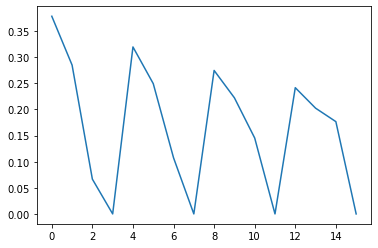

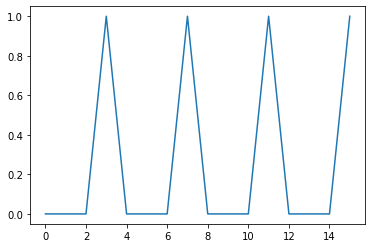

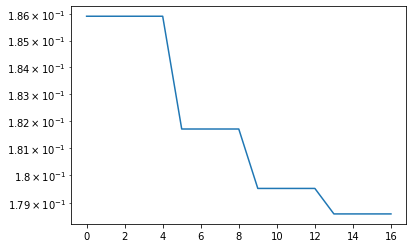

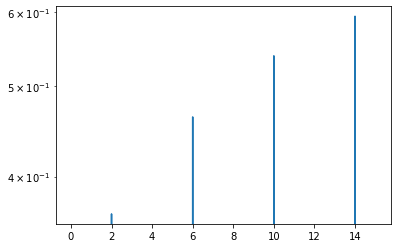

In [119]:
#######################
###### debugging ######
#######################

np.random.seed(seed)
init_val = 1
W1_init = np.random.uniform(0, init_val, size=(layers[1], layers[0]))
W2_init = np.random.uniform(0, init_val, size=(layers[2], layers[1]))
bias_init = [np.zeros(layers[1]), np.zeros(layers[2])]
W_init = [W1_init, W2_init]

r_array, e_array, W_array, _, loss_array, acc_array = calc_net(0.1, layers, tanh, d_tanh, W_init, inputs, 4, 'pbp',
                                learn_W = [True]*(len(layers)-1), bias = bias_init, learn_bias = [False]*(len(layers)-1),
                                acc_measure = 'single', print_steps=0)

plt.plot(loss_array)
plt.show()
plt.plot(acc_array)
plt.show()

W0_std_array = [np.std(np.abs(W_array[i][0])) for i in range(len(W_array))]
plt.plot(W0_std_array)
plt.yscale('log')
plt.show()

e2_array = [e_array[i][2] for i in range(len(e_array))]
plt.plot(e2_array)
plt.yscale('log')
plt.show()

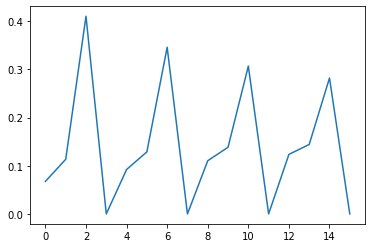

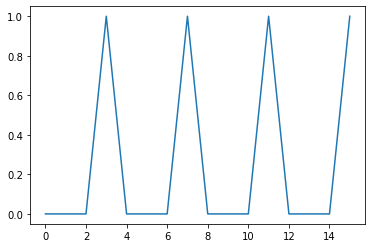

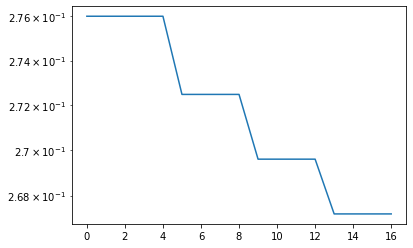

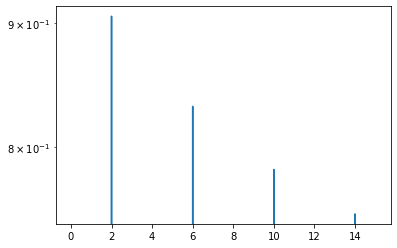

In [143]:
np.random.seed(10)
init_val = 1
W1_init = np.random.uniform(0, init_val, size=(layers[1], layers[0]))
W2_init = np.random.uniform(0, init_val, size=(layers[2], layers[1]))
bias_init = [np.zeros(layers[1]), np.zeros(layers[2])]
W_init = [W1_init, W2_init]

r_array, e_array, W_array, B_array, loss_array, acc_array = calc_net(0.1, layers, tanh, d_tanh, W_init, inputs, 4, 'gen-pbp',
                                learn_W = [True]*(len(layers)-1), bias = bias_init, learn_bias = [False]*(len(layers)-1),
                                acc_measure = 'single', print_steps=0, pinv_recalc = 4)

plt.plot(loss_array)
plt.show()
plt.plot(acc_array)
plt.show()

W0_std_array = [np.std(np.abs(W_array[i][0])) for i in range(len(W_array))]
plt.plot(W0_std_array)
plt.yscale('log')
plt.show()

e2_array = [e_array[i][2] for i in range(len(e_array))]
plt.plot(e2_array)
plt.yscale('log')
plt.show()

In [142]:
B_array[0][0] - B_array[-1][0]

array([[-1.32100753,  0.3054498 , -0.31132953],
       [ 2.23982253, -0.65888345,  1.72092605]])

In [140]:
acc_array

[0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0]

## cont after debugging

In [26]:
seeds = 20

# for model dyn-pseudo, we also sample over backwards learning rate
# because this scans takes more time (it also scanes over the backwards learning rate), we restrict to lr = 0.1, best case found in the BP and PBP runs
# for reference, we also run with bw_lr = 0, which reproduces FA

lrs = [0.1]
bw_lrs = [0.0, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
# bw_lrs = [1e-4]

r_array = []
W_array = []
B_array = []

for i in range(len(lrs)):
    r_array.append([])
    W_array.append([])
    B_array.append([])
    
    for j in range(len(bw_lrs)):
        r_array[i].append([])
        W_array[i].append([])
        B_array[i].append([])    
        acc = []
        for k in range(seeds):
            r_array[i][j].append([])
            W_array[i][j].append([])
            B_array[i][j].append([]) 

            np.random.seed(range(seeds)[k])
            W1_init = np.random.uniform(0, init_val, size=(layers[1], layers[0]))
            W2_init = np.random.uniform(0, init_val, size=(layers[2], layers[1]))
            bias_init = [np.zeros(layers[1]), np.zeros(layers[2])]
            W_init = [W1_init, W2_init]

            r, _, W, B, _, acc_array = calc_net(lrs[i], layers, tanh, d_tanh, W_init, inputs, steps, 'dyn-pbp',
                                            learn_W = [True]*(len(layers)-1), bias = bias_init, learn_bias = [False]*(len(layers)-1),
                                            acc_measure = 'single', print_steps=0, pinv_recalc=1, alpha = 0.1, bw_lr = bw_lrs[j])
            B_array[i][j][k].append(B)
            W_array[i][j][k].append(W)
            r_array[i][j][k].append(r)
            acc.append(acc_array)
        print('model:', 'dyn-pbp', 'lr:', lrs[i], 'bw_lr:', bw_lrs[j], 'accuracy:', np.mean(np.array(acc)[:,-100:]), '+-', np.std(np.array(acc)[:,-100:])/np.sqrt(seeds))

model: dyn-pbp lr: 0.1 bw_lr: 0.0 accuracy: 0.85 +- 0.07984359711335656
model: dyn-pbp lr: 0.1 bw_lr: 1e-05 accuracy: 0.85 +- 0.07984359711335656
model: dyn-pbp lr: 0.1 bw_lr: 5e-05 accuracy: 0.775 +- 0.0933742469849155
model: dyn-pbp lr: 0.1 bw_lr: 0.0001 accuracy: 0.8125 +- 0.08727650027355588
model: dyn-pbp lr: 0.1 bw_lr: 0.0005 accuracy: 0.85 +- 0.07984359711335656
model: dyn-pbp lr: 0.1 bw_lr: 0.001 accuracy: 0.6625 +- 0.10573404134903763
model: dyn-pbp lr: 0.1 bw_lr: 0.005 accuracy: 0.2875 +- 0.10120369311443134
model: dyn-pbp lr: 0.1 bw_lr: 0.01 accuracy: 0.25 +- 0.09682458365518541
model: dyn-pbp lr: 0.1 bw_lr: 0.05 accuracy: 0.25 +- 0.09682458365518541
model: dyn-pbp lr: 0.1 bw_lr: 0.1 accuracy: 0.25 +- 0.09682458365518541


In [27]:
# for model dyn-pseudo, we also sample over backwards learning rate
# because this scans takes more time (it also scanes over the backwards learning rate), we restrict to lr = 0.1, best case found in the BP and PBP runs
# for reference, we also run with bw_lr = 0, which reproduces FA

lrs = [0.1]
bw_lrs = [2e-4, 3e-4, 4e-4, 6e-4, 7e-4, 8e-4, 9e-4]
# bw_lrs = [1e-4]

r_array = []
W_array = []
B_array = []

for i in range(len(lrs)):
    r_array.append([])
    W_array.append([])
    B_array.append([])
    
    for j in range(len(bw_lrs)):
        r_array[i].append([])
        W_array[i].append([])
        B_array[i].append([])    
        acc = []
        for k in range(seeds):
            r_array[i][j].append([])
            W_array[i][j].append([])
            B_array[i][j].append([]) 

            np.random.seed(range(seeds)[k])
            W1_init = np.random.uniform(0, init_val, size=(layers[1], layers[0]))
            W2_init = np.random.uniform(0, init_val, size=(layers[2], layers[1]))
            bias_init = [np.zeros(layers[1]), np.zeros(layers[2])]
            W_init = [W1_init, W2_init]

            r, _, W, B, _, acc_array = calc_net(lrs[i], layers, tanh, d_tanh, W_init, inputs, steps, 'dyn-pbp',
                                            learn_W = [True]*(len(layers)-1), bias = bias_init, learn_bias = [False]*(len(layers)-1),
                                            acc_measure = 'single', print_steps=0, pinv_recalc=1, alpha = 0.1, bw_lr = bw_lrs[j])
            B_array[i][j][k].append(B)
            W_array[i][j][k].append(W)
            r_array[i][j][k].append(r)
            acc.append(acc_array)
        print('model:', 'dyn-pbp', 'lr:', lrs[i], 'bw_lr:', bw_lrs[j], 'accuracy:', np.mean(np.array(acc)[:,-100:]), '+-', np.std(np.array(acc)[:,-100:])/np.sqrt(seeds))

model: dyn-pbp lr: 0.1 bw_lr: 0.0002 accuracy: 0.778 +- 0.09292900515985307
model: dyn-pbp lr: 0.1 bw_lr: 0.0003 accuracy: 0.8125 +- 0.08727650027355588
model: dyn-pbp lr: 0.1 bw_lr: 0.0004 accuracy: 0.85 +- 0.07984359711335656
model: dyn-pbp lr: 0.1 bw_lr: 0.0006 accuracy: 0.8125 +- 0.08727650027355588
model: dyn-pbp lr: 0.1 bw_lr: 0.0007 accuracy: 0.8 +- 0.08944271909999159
model: dyn-pbp lr: 0.1 bw_lr: 0.0008 accuracy: 0.8125 +- 0.08727650027355588
model: dyn-pbp lr: 0.1 bw_lr: 0.0009 accuracy: 0.775 +- 0.0933742469849155


In [214]:
pinv_recalc = 4
lrs = [0.1]
bw_lrs = [0.0, 1e-5, 5e-5, 1e-4, 5e-4]

cos_sim_array = []

for lr in range(len(B_array)):
    cos_sim_array.append([])
    
    for bw_lr in range(len(B_array[0])):
        cos_sim_array[lr].append([])
    
        for seed in range(len(B_array[0][0])):
            cos_sim_array[lr][bw_lr].append([])
        
            for layer in range(len(B_array[0][0][0][0][0])):
                cos_sim_array[lr][bw_lr][seed].append([])
            
                for step in range(steps):
                
                    r_batch = [r_array[lr][bw_lr][seed][0][-pinv_recalc:][i][layer] for i in range(pinv_recalc)]
                    
                    # print(np.array(r_batch).T)
                    # print(W_array[lr][bw_lr][seed][0][step][layer])

                    dspinv = ds_pinv(np.array(r_batch), W_array[lr][bw_lr][seed][0][step][layer])
                    
                    cossim = cos_sim(np.array(B_array[lr][bw_lr][seed][0][step][layer]), dspinv)
                    
                    cos_sim_array[lr][bw_lr][seed][layer].append(cossim.copy())


ValueError: ds-pinv has not converged to real matrix

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

layer = 0

for lr in range(len(cos_sim_array)):    
    for bw_lr in range(len(cos_sim_array[0])):    
        for seed in range(len(cos_sim_array[0][0])):
            label = 'lr ' + str(lr) + 'bw lr ' + str(bw_lr) + 'layer ' + str(layer)
            ax[0].plot(cos_sim_array[lr][bw_lr][seed][layer], label=label)


layer = 1

for lr in range(len(cos_sim_array)):    
    for bw_lr in range(len(cos_sim_array[0])):    
        for seed in range(len(cos_sim_array[0][0])):
            label = 'lr ' + str(lr) + 'bw lr ' + str(bw_lr) + 'layer ' + str(layer)
            ax[1].plot(cos_sim_array[lr][bw_lr][seed][layer])
        
plt.show()

A little aside on Feedback Alignment: can it change the sign of W?

In [13]:
acc = []
loss = []
r = []
W = []
e = []

for seed in range(seeds):
    
    np.random.seed(seed)
    W1_init = np.random.uniform(0, 1, size=(layers[1], layers[0]))
    W2_init = np.random.uniform(0, 1, size=(layers[2], layers[1]))
    bias_init = [np.zeros(layers[1]), np.zeros(layers[2])]
    W_init = [W1_init, W2_init]
    
    r_array_bp, e_array_bp, W_array_bp, B_array_bp, loss_array_bp, acc_array_bp = calc_net(0.1, layers, tanh, d_tanh, W_init, inputs, steps, 'bp', learn_W = [True]*(len(layers)-1), bias = bias_init, learn_bias = [False]*(len(layers)-1), acc_measure = 'single', print_steps=0)
    r_array_fa, e_array_fa, W_array_fa, B_array_fa, loss_array_fa, acc_array_fa = calc_net(0.1, layers, tanh, d_tanh, W_init, inputs, steps, 'fa', learn_W = [True]*(len(layers)-1), bias = bias_init, learn_bias = [False]*(len(layers)-1), acc_measure = 'single', print_steps=0)
    
    r.append([r_array_bp, r_array_fa])
    e.append([e_array_bp, e_array_fa])
    W.append([W_array_bp, W_array_fa])
    acc.append([acc_array_bp, acc_array_fa])
    loss.append([loss_array_bp, loss_array_fa])

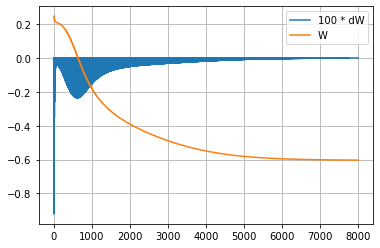

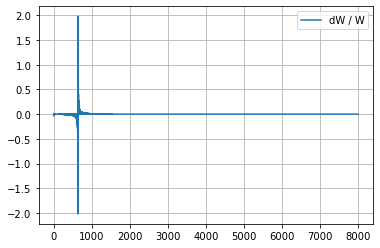

In [56]:
# FA can change sign of W, if delta W > W:

W = np.array([W_array_fa[seed][0] for seed in range(len(W_array_fa))])
plt.plot(100*(W[:,1,0][1:] - W[:,1,0][0:-1]), label='100 * dW')
plt.plot(W[:,1,0], label='W')
plt.grid()
plt.legend()
plt.show()

plt.plot((W[:,1,0][1:] - W[:,1,0][0:-1])/W[:,1,0][0:-1], label='dW / W')
plt.grid()
plt.legend()
plt.show()

In [59]:
######### END of aside

From this, we use the best values and rerun for more seeds:

In [149]:
# define parameters of model
lr_bp = 0.1
lr_fa = 0.1
lr_pbp = 0.1
lr_gen = 0#0.001
lr_dyn = 0.1
bw_lr =  1e-4

layers = [2, 3, 1]

inputs = np.array([[1, 0], [0, 1], [1, 1], [0, 0]])
targets = np.array([1, 1, 0, 0])

steps = 4000
seeds = 20

In [154]:
acc = []
loss = []

# for dyn-pseudo, we also record the backwards arrays
B_array = []
W_array = []
r_array = []

for seed in range(seeds):
    
    np.random.seed(seed)
    init_val = 1
    W1_init = np.random.uniform(0, init_val, size=(layers[1], layers[0]))
    W2_init = np.random.uniform(0, init_val, size=(layers[2], layers[1]))
    bias_init = [np.zeros(layers[1]), np.zeros(layers[2])]
    W_init = [W1_init, W2_init]
    
    _, _, _, _, loss_array_bp, acc_array_bp = calc_net(lr_bp, layers, tanh, d_tanh, W_init, inputs, steps, 'bp', learn_W = [True]*(len(layers)-1), bias = bias_init, learn_bias = [False]*(len(layers)-1), acc_measure = 'single', print_steps=0)
    _, _, _, _, loss_array_fa, acc_array_fa = calc_net(lr_fa, layers, tanh, d_tanh, W_init, inputs, steps, 'fa', learn_W = [True]*(len(layers)-1), bias = bias_init, learn_bias = [False]*(len(layers)-1), acc_measure = 'single', print_steps=0)
    _, _, _, _, loss_array_pbp, acc_array_pbp = calc_net(lr_pbp, layers, tanh, d_tanh, W_init, inputs, steps, 'pbp', learn_W = [True]*(len(layers)-1), bias = bias_init, learn_bias = [False]*(len(layers)-1), acc_measure = 'single', print_steps=0, pinv_recalc=40)
    _, _, _, _, loss_array_gen, acc_array_gen = calc_net(lr_gen, layers, tanh, d_tanh, W_init, inputs, steps, 'gen-pbp', learn_W = [True]*(len(layers)-1), bias = bias_init, learn_bias = [False]*(len(layers)-1), acc_measure = 'single', print_steps=0, pinv_recalc=4)
    r, _, W, B, loss_array_dyn, acc_array_dyn = calc_net(lr_dyn, layers, tanh, d_tanh, W_init, inputs, steps, 'dyn-pbp', learn_W = [True]*(len(layers)-1), bias = bias_init,
                                                      learn_bias = [False]*(len(layers)-1), acc_measure = 'single', print_steps=0, pinv_recalc=1, alpha = 0.1, bw_lr = bw_lr)
    
    B_array.append(B)
    W_array.append(W)
    r_array.append(r)
    acc.append([acc_array_bp, acc_array_fa, acc_array_pbp, acc_array_gen, acc_array_dyn])
    loss.append([loss_array_bp, loss_array_fa, loss_array_pbp, loss_array_gen, loss_array_dyn])

In [155]:
print('total accuracy over', seeds, 'seeds (last 100 steps): ')

labels = ['bp', 'fa', 'pbp', 'gen-pbp', 'dyn-pbp']


for i in range(len(labels)):
    print(labels[i], ':', np.mean(np.transpose(np.array(acc)[:,:,-100:], axes=(1,0,2))[i]), ' +- ',  sem(np.mean(np.transpose(np.array(acc)[:,:,-100:], axes=(1,0,2))[0], axis = 1)))

total accuracy over 20 seeds (last 100 steps): 
bp : 1.0  +-  0.0
fa : 0.85  +-  0.0
pbp : 0.9625  +-  0.0
gen-pbp : 0.3  +-  0.0
dyn-pbp : 0.925  +-  0.0


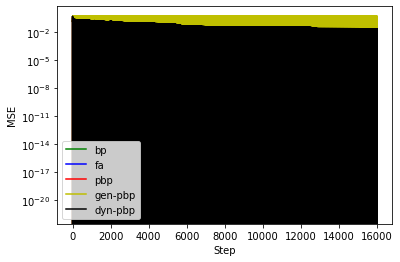

In [156]:
per_steps = 1

for i in range(len(labels)):
    data = np.transpose(np.array(loss), axes = (1,0,2))[i]
    plt.plot(np.linspace(0, len(data[0][::per_steps]), len(data[0][::per_steps])), np.mean(data, axis=0)[::per_steps], label=labels[i], c=styles[i])
    
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.legend()
plt.show()

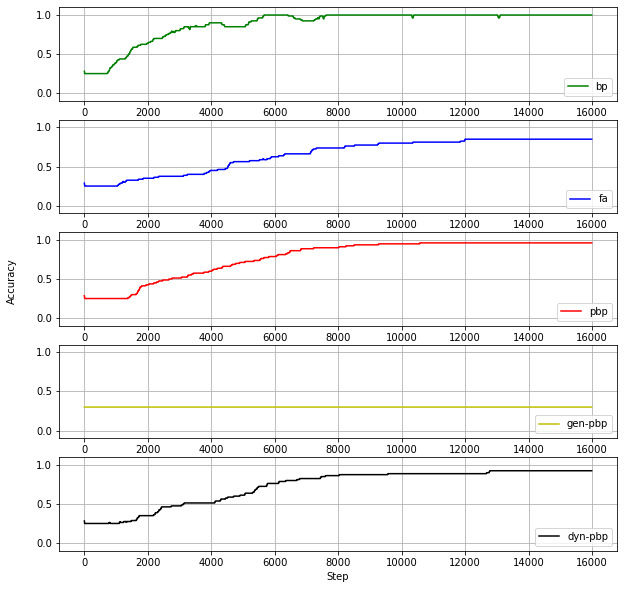

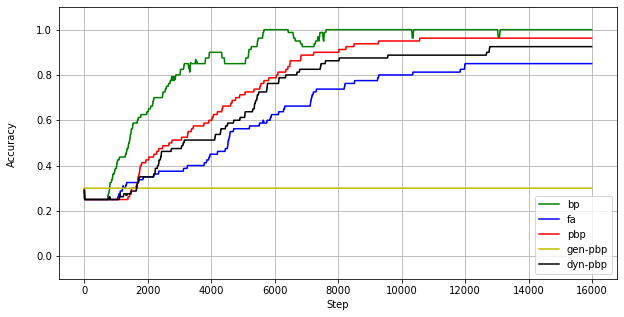

In [157]:
fig, ax = plt.subplots(len(labels), 1, figsize=(10,10))

# we take the mean and convolve the result in time to make it more readable
# per_steps sets the bin size of the convolution window
per_steps = 1
N = len(np.transpose(np.array(acc), axes = (1,0,2))[0]) // per_steps

for i in range(len(labels)):
    data = np.transpose(np.array(acc), axes = (1,0,2))[i]
    y = np.convolve(np.mean(data, axis=0), np.ones(N)/N, mode='valid')
    ax[i].plot(y, label=labels[i], c=styles[i])
    ax[i].legend(loc='lower right')
    ax[i].set_ylim([-0.1,1.1])
    ax[i].grid()

plt.xlabel('Step')
fig.text(0.06, 0.5, 'Accuracy', ha='center', va='center', rotation='vertical')
plt.show()



fig, ax = plt.subplots(1, 1, figsize=(10,5))

per_steps = 1000
N = len(data[0]) // per_steps

for i in range(len(labels)):
    data = np.transpose(np.array(acc), axes = (1,0,2))[i]
    y = np.convolve(np.mean(data, axis=0), np.ones(N)/N, mode='valid')
    ax.plot(y, label=labels[i], c=styles[i])
    ax.legend(loc='lower right')
    ax.set_ylim([-0.1,1.1])
    ax.grid()

plt.xlabel('Step')
fig.text(0.06, 0.5, 'Accuracy', ha='center', va='center', rotation='vertical')
plt.show()

In [19]:
####### More testing